In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

### 数据导入

In [2]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### 数据分析及预处理

###### 1. Type Check

In [3]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [4]:
df = df.astype(np.float16)

###### 2. Missing value check

In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

###### 3. Duplicate Check

In [6]:
df.duplicated().sum()

0

###### 4. Distribution analysis

In [7]:
def plot_his(df, column_name):
    column = df[column_name]
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, kde=True, bins=30)
    plt.title(column_name + ' Distribution')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

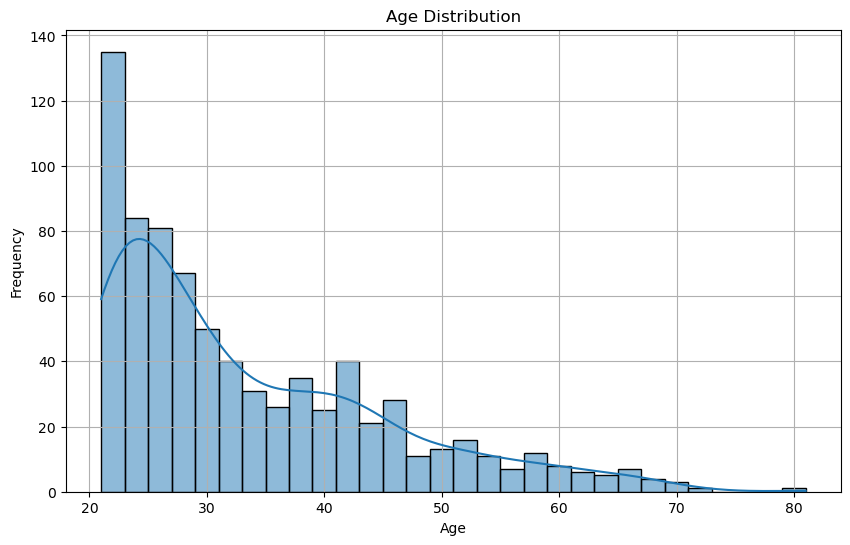

In [8]:
plot_his(df, 'Age')

###### 5. Target balance check

In [9]:
outcome_counts = df['Outcome'].value_counts()
labels = ['No Diabetes (0)', 'Diabetes (1)']
sizes = [outcome_counts[0], outcome_counts[1]]

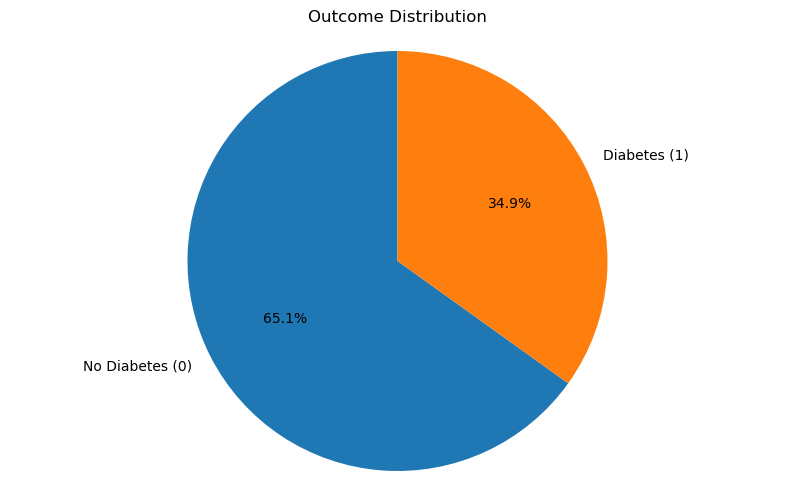

In [10]:
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Outcome Distribution')
plt.axis('equal')
plt.show()

###### 6. Correlation matrix

In [11]:
corr_matrix = df.corr()

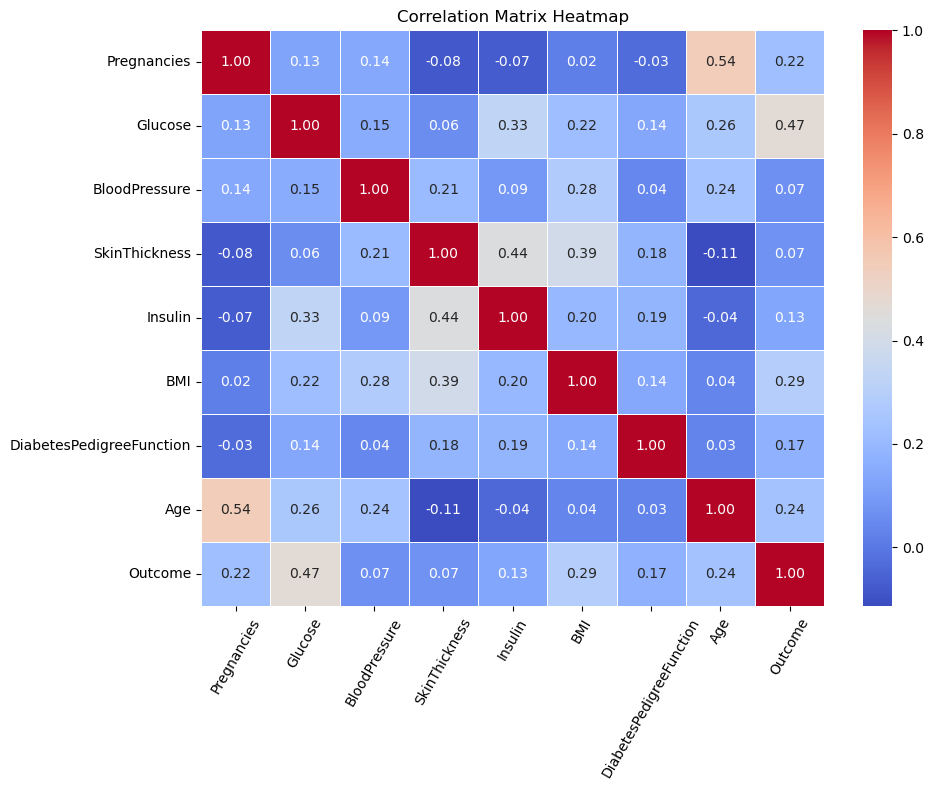

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###### 7. Feature importance

In [13]:
features = df.drop(columns=['Outcome'])

In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [15]:
df_x = pd.DataFrame(data=scaled_features)
df_y = df['Outcome']

In [16]:
rfc = RandomForestClassifier()
rfc.fit(df_x, df_y)

RandomForestClassifier()

In [17]:
importance = rfc.feature_importances_
feature_name = df.drop(columns=['Outcome']).columns

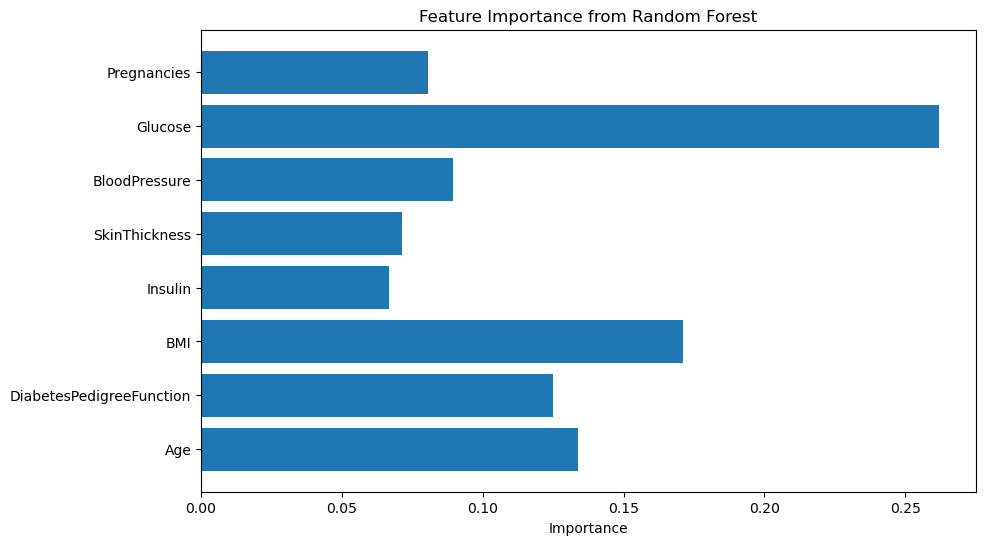

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(feature_name, importance)
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show()

###### 8. 2-d visualization

In [19]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_features)

In [20]:
pca_df = pd.DataFrame(data=reduced, columns=['PC1', 'PC2'])
pca_df['Outcome'] = df['Outcome']

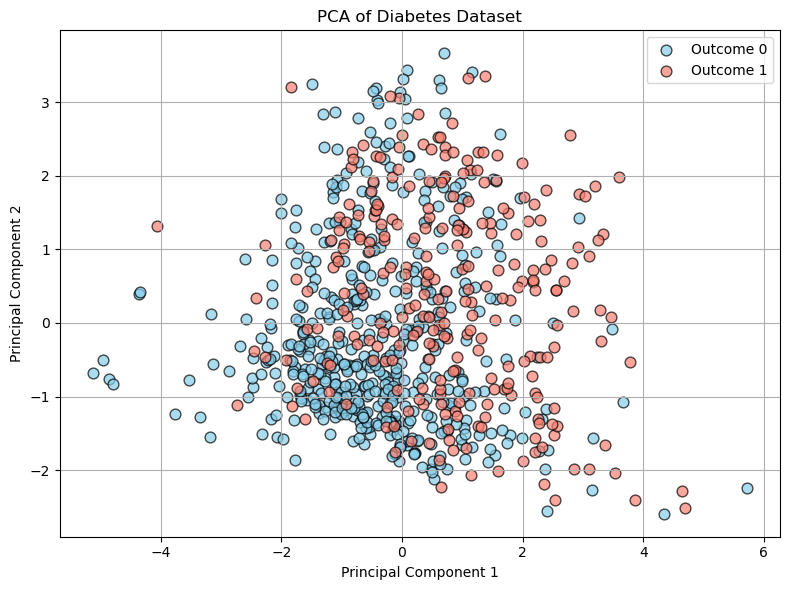

In [21]:
plt.figure(figsize=(8, 6))
colors = {0: 'skyblue', 1: 'salmon'}
for label in [0, 1]:
    subset = pca_df[pca_df['Outcome'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Outcome {label}', 
                color=colors[label], alpha=0.7, edgecolor='k', s=60)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.legend()
plt.grid(True)
plt.tight_layout()

### Model development

###### 1. xgboost

In [22]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=1)

In [23]:
xgb = XGBClassifier(max_depth=4,
    n_estimators=50,
    learning_rate=0.05,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1,
    eval_metric='aucpr', 
    scale_pos_weight=1.5
)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:
train_pred = xgb.predict(x_train)

In [25]:
acc_train = accuracy_score(y_train, train_pred)
acc_train

0.8640595903165735

###### 测试集表现

In [26]:
pred = xgb.predict(x_test)

In [27]:
acc = accuracy_score(y_test, pred)
recall = recall_score(y_test, pred)
precision = precision_score(y_test, pred)
f1 = f1_score(y_test, pred)

print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7965
Recall: 0.7647
Precision: 0.7065
F1 Score: 0.7345


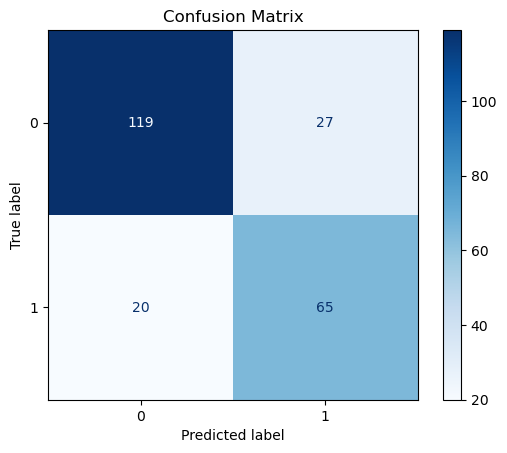

In [28]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

###### 2. Decision tree

In [29]:
dt = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    criterion="gini",
    random_state=42
)

In [30]:
dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [31]:
dt_pred = xgb.predict(x_test)

In [32]:
acc_dt = accuracy_score(y_test, dt_pred)
recall_dt = recall_score(y_test, dt_pred)
precision_dt = precision_score(y_test, dt_pred)
f1_dt = f1_score(y_test, dt_pred)

print(f"Accuracy: {acc_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")

Accuracy: 0.7965
Recall: 0.7647
Precision: 0.7065
F1 Score: 0.7345


###### 3. DNN

In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [34]:
input_rows, input_column = x_train.shape
output_size = 2
batch_size = 16
num_epochs = 10

In [35]:
class dnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_column, 256),
            nn.Sigmoid()
        )
        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.Sigmoid()
        )
        self.out = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.out(x)
        return x

In [36]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

In [37]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
print("Unique labels:", y_train_tensor.unique())
print("Label dtype:", y_train_tensor.dtype)

Unique labels: tensor([0, 1])
Label dtype: torch.int64


In [39]:
dia_nn = dnn()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dia_nn.parameters(), lr=0.001)

In [41]:
for epoch in range(num_epochs):
    dia_nn.train()
    total_loss = 0
    for inputs, labels in train_loader:

        outputs = dia_nn(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # 评估模型在测试集上的准确率
    dia_nn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = dia_nn(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%\n")

Epoch [1/10], Loss: 0.6563
Test Accuracy: 63.20%

Epoch [2/10], Loss: 0.5969
Test Accuracy: 72.29%

Epoch [3/10], Loss: 0.5572
Test Accuracy: 76.62%

Epoch [4/10], Loss: 0.5133
Test Accuracy: 79.22%

Epoch [5/10], Loss: 0.5035
Test Accuracy: 78.79%

Epoch [6/10], Loss: 0.4881
Test Accuracy: 78.35%

Epoch [7/10], Loss: 0.4890
Test Accuracy: 80.52%

Epoch [8/10], Loss: 0.4952
Test Accuracy: 78.35%

Epoch [9/10], Loss: 0.4932
Test Accuracy: 77.92%

Epoch [10/10], Loss: 0.4834
Test Accuracy: 77.92%

